<a href="https://colab.research.google.com/github/junkyul/dqn_colab/blob/main/DQN_Tutorial_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Licence


In [ ]:

#Licence
#Copyright 2021 Google LLC.
#SPDX-License-Identifier: Apache-2.0

#DQN Tutorial
This tutorial is an adaptation of the much deeper and wider tutorial that can be found <a href="https://github.com/eemlcommunity/PracticalSessions2020/blob/master/rl/EEML2020_RL_Tutorial.ipynb">here</a>.

During this tutorial, we will try to reimplement, partly from scratch, a simple version of <a href="https://arxiv.org/abs/1312.5602">Deep Q-learning</a>.

*italicized text*##Installation

### Install required libraries

1. [Acme](https://github.com/deepmind/acme) is a library of reinforcement learning (RL) agents and agent building blocks. Acme strives to expose simple, efficient, and readable agents, that serve both as reference implementations of popular algorithms and as strong baselines, while still providing enough flexibility to do novel research. The design of Acme also attempts to provide multiple points of entry to the RL problem at differing levels of complexity.


2. [Haiku](https://github.com/deepmind/dm-haiku) is a simple neural network library for JAX developed by some of the authors of Sonnet, a neural network library for TensorFlow.

3. [dm_env](https://github.com/deepmind/dm_env): DeepMind Environment API, which will be covered in more details in the [Environment subsection](https://colab.research.google.com/drive/1oKyyhOFAFSBTpVnmuOm9HXh5D5ekqhh5#scrollTo=I6KuVGSk4uc9) below.1

In [ ]:
#@title Installations  { form-width: "30%" }

!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[jax]
!pip install dm-acme[tf]
!pip install dm-acme[envs]
!pip install dm-env
!pip install dm-haiku
!pip install chex
!sudo apt-get install -y xvfb ffmpeg
!pip install imageio

from IPython.display import clear_output
clear_output()

In [ ]:
#@title Imports  { form-width: "30%" }

import IPython

import acme
from acme import environment_loop
from acme import datasets
from acme import types
from acme import specs
from acme import wrappers
from acme.wrappers import gym_wrapper
from acme.agents.jax import dqn
from acme.adders import reverb as adders
from acme.utils import counting
from acme.utils import loggers
import base64
import chex
import collections
from collections import namedtuple
import dm_env
import enum
import functools
import gym
import haiku as hk
import io
import itertools
import jax
from jax import tree_util
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import reverb
import rlax
import time

import warnings

np.set_printoptions(precision=3, suppress=1)

%matplotlib inline

# 1. Environment

We will focus on a simple grid world environment for this practical session. 


<img src="https://drive.google.com/uc?id=1qBjh_PRdZ4GWTDqB9pmjLEOlUAsOfrZi" width="500" />



This environment consists of either walls and empty cells. The agent starts from an initial location and needs to navigate to reach a goal location. 

In [ ]:
#@title Gridworld Implementation { form-width: "30%" }


class ObservationType(enum.IntEnum):
  STATE_INDEX = enum.auto()
  AGENT_ONEHOT = enum.auto()
  GRID = enum.auto()
  AGENT_GOAL_POS = enum.auto()


class GridWorld(dm_env.Environment):

  def __init__(self,
               layout,
               start_state,
               goal_state=None,
               observation_type=ObservationType.STATE_INDEX,
               discount=0.9,
               penalty_for_walls=-5,
               reward_goal=10,
               max_episode_length=None,
               randomize_goals=False):
    """Build a grid environment.

    Simple gridworld defined by a map layout, a start and a goal state.

    Layout should be a NxN grid, containing:
      * 0: empty
      * -1: wall
      * Any other positive value: value indicates reward; episode will terminate

    Args:
      layout: NxN array of numbers, indicating the layout of the environment.
      start_state: Tuple (y, x) of starting location.
      goal_state: Optional tuple (y, x) of goal location. Will be randomly
        sampled once if None.
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the 
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels. 
          First channel contains walls (1 if wall, 0 otherwise), second the 
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with 
          (agent_y, agent_x, goal_y, goal_x)
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      reward_goal: Reward added when finding the goal (should be positive).
      max_episode_length: If set, will terminate an episode after this many 
        steps.
      randomize_goals: If true, randomize goal at every episode.
    """
    if observation_type not in ObservationType:
      raise ValueError('observation_type should be a ObservationType instace.')
    self._layout = np.array(layout)
    self._start_state = start_state
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount
    self._penalty_for_walls = penalty_for_walls
    self._reward_goal = reward_goal
    self._observation_type = observation_type
    self._layout_dims = self._layout.shape
    self._max_episode_length = max_episode_length
    self._num_episode_steps = 0
    self._randomize_goals = randomize_goals
    if goal_state is None:
      # Randomly sample goal_state if not provided
      goal_state = self._sample_goal()
    self.goal_state = goal_state

  def _sample_goal(self):
    """Randomly sample reachable non-starting state."""
    # Sample a new goal
    n = 0
    max_tries = 1e5
    while n < max_tries:
      goal_state = tuple(np.random.randint(d) for d in self._layout_dims)
      if goal_state != self._state and self._layout[goal_state] == 0:
        # Reachable state found!
        return goal_state
      n += 1
    raise ValueError('Failed to sample a goal state.')

  @property
  def number_of_states(self):
    return self._number_of_states

  @property
  def goal_state(self):
    return self._goal_state

  def set_state(self, x, y):
    self._state = (y, x)

  @goal_state.setter
  def goal_state(self, new_goal):
    if new_goal == self._state or self._layout[new_goal] < 0:
      raise ValueError('This is not a valid goal!')
    # Zero out any other goal
    self._layout[self._layout > 0] = 0
    # Setup new goal location
    self._layout[new_goal] = self._reward_goal
    self._goal_state = new_goal

  def observation_spec(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      return specs.Array(
          shape=self._layout_dims,
          dtype=np.float32,
          name='observation_agent_onehot')
    elif self._observation_type is ObservationType.GRID:
      return specs.Array(
          shape=self._layout_dims + (3,),
          dtype=np.float32,
          name='observation_grid')
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return specs.Array(
          shape=(4,), dtype=np.float32, name='observation_agent_goal_pos')
    elif self._observation_type is ObservationType.STATE_INDEX:
      return specs.DiscreteArray(
          self._number_of_states, dtype=int, name='observation_state_index')

  def action_spec(self):
    return specs.DiscreteArray(4, dtype=int, name='action')

  def get_obs(self):
    if self._observation_type is ObservationType.AGENT_ONEHOT:
      obs = np.zeros(self._layout.shape, dtype=np.float32)
      # Place agent
      obs[self._state] = 1
      return obs
    elif self._observation_type is ObservationType.GRID:
      obs = np.zeros(self._layout.shape + (3,), dtype=np.float32)
      obs[..., 0] = self._layout < 0
      obs[self._state[0], self._state[1], 1] = 1
      obs[self._goal_state[0], self._goal_state[1], 2] = 1
      return obs
    elif self._observation_type is ObservationType.AGENT_GOAL_POS:
      return np.array(self._state + self._goal_state, dtype=np.float32)
    elif self._observation_type is ObservationType.STATE_INDEX:
      y, x = self._state
      return y * self._layout.shape[1] + x

  def reset(self):
    self._state = self._start_state
    self._num_episode_steps = 0
    if self._randomize_goals:
      self.goal_state = self._sample_goal()
    return dm_env.TimeStep(
        step_type=dm_env.StepType.FIRST,
        reward=None,
        discount=None,
        observation=self.get_obs())

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError(
          'Invalid action: {} is not 0, 1, 2, or 3.'.format(action))

    new_y, new_x = new_state
    step_type = dm_env.StepType.MID
    if self._layout[new_y, new_x] == -1:  # wall
      reward = self._penalty_for_walls
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
      step_type = dm_env.StepType.LAST

    self._state = new_state
    self._num_episode_steps += 1
    if (self._max_episode_length is not None and
        self._num_episode_steps >= self._max_episode_length):
      step_type = dm_env.StepType.LAST
    return dm_env.TimeStep(
        step_type=step_type,
        reward=np.float32(reward),
        discount=discount,
        observation=self.get_obs())

  def plot_grid(self, add_start=True):
    plt.figure(figsize=(4, 4))
    plt.imshow(self._layout <= -1, interpolation='nearest')
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    # Add start/goal
    if add_start:
      plt.text(
          self._start_state[1],
          self._start_state[0],
          r'$\mathbf{S}$',
          fontsize=16,
          ha='center',
          va='center')
    plt.text(
        self._goal_state[1],
        self._goal_state[0],
        r'$\mathbf{G}$',
        fontsize=16,
        ha='center',
        va='center')
    h, w = self._layout.shape
    for y in range(h - 1):
      plt.plot([-0.5, w - 0.5], [y + 0.5, y + 0.5], '-k', lw=2)
    for x in range(w - 1):
      plt.plot([x + 0.5, x + 0.5], [-0.5, h - 0.5], '-k', lw=2)

  def plot_state(self, return_rgb=False):
    self.plot_grid(add_start=False)
    # Add the agent location
    plt.text(
        self._state[1],
        self._state[0],
        u'😃',
        fontname='symbola',
        fontsize=18,
        ha='center',
        va='center',
    )
    if return_rgb:
      fig = plt.gcf()
      plt.axis('tight')
      plt.subplots_adjust(0, 0, 1, 1, 0, 0)
      fig.canvas.draw()
      data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
      w, h = fig.canvas.get_width_height()
      data = data.reshape((h, w, 3))
      plt.close(fig)
      return data

  def plot_policy(self, policy):
    action_names = [
        r'$\uparrow$', r'$\rightarrow$', r'$\downarrow$', r'$\leftarrow$'
    ]
    self.plot_grid()
    plt.title('Policy Visualization')
    h, w = self._layout.shape
    for y in range(h):
      for x in range(w):
        # if ((y, x) != self._start_state) and ((y, x) != self._goal_state):
        if (y, x) != self._goal_state:
          action_name = action_names[policy[y, x]]
          plt.text(x, y, action_name, ha='center', va='center')

  def plot_greedy_policy(self, q):
    greedy_actions = np.argmax(q, axis=2)
    self.plot_policy(greedy_actions)


def build_gridworld_task(task,
                         discount=0.9,
                         penalty_for_walls=-5,
                         observation_type=ObservationType.STATE_INDEX,
                         max_episode_length=200):
  """Construct a particular Gridworld layout with start/goal states.

  Args:
      task: string name of the task to use. One of {'simple', 'obstacle', 
        'random_goal'}.
      discount: Discounting factor included in all Timesteps.
      penalty_for_walls: Reward added when hitting a wall (should be negative).
      observation_type: Enum observation type to use. One of:
        * ObservationType.STATE_INDEX: int32 index of agent occupied tile.
        * ObservationType.AGENT_ONEHOT: NxN float32 grid, with a 1 where the 
          agent is and 0 elsewhere.
        * ObservationType.GRID: NxNx3 float32 grid of feature channels. 
          First channel contains walls (1 if wall, 0 otherwise), second the 
          agent position (1 if agent, 0 otherwise) and third goal position
          (1 if goal, 0 otherwise)
        * ObservationType.AGENT_GOAL_POS: float32 tuple with 
          (agent_y, agent_x, goal_y, goal_x).
      max_episode_length: If set, will terminate an episode after this many 
        steps.
  """
  tasks_specifications = {
      'simple': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (7, 2)
      },
      'obstacle': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, -1, 0, 0, -1],
              [-1, 0, 0, 0, -1, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          'goal_state': (2, 8)
      },
      'random_goal': {
          'layout': [
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, -1, -1, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1],
              [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
          ],
          'start_state': (2, 2),
          # 'randomize_goals': True
      },
  }
  return GridWorld(
      discount=discount,
      penalty_for_walls=penalty_for_walls,
      observation_type=observation_type,
      max_episode_length=max_episode_length,
      **tasks_specifications[task])


def setup_environment(environment):
  # Make sure the environment outputs single-precision floats.
  environment = wrappers.SinglePrecisionWrapper(environment)

  # Grab the spec of the environment.
  environment_spec = specs.make_environment_spec(environment)

  return environment, environment_spec


We will use two distinct tabular GridWorlds:
* `simple` where the goal is at the bottom left of the grid, little navigation required.
* `obstacle` where the goal is behind an obstacle to avoid.

You can visualize the grid worlds by running the cell below. 

Note that `S` indicates the start state and `G` indicates the goal. 


Text(0.5, 1.0, 'Obstacle')

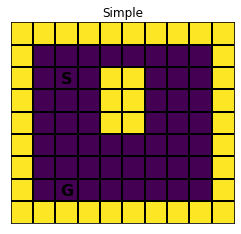

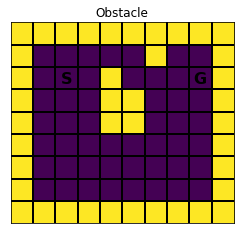

In [ ]:
# @title Visualise gridworlds { form-width: "30%" }

# Instantiate two tabular environments, a simple task, and one that involves
# the avoidance of an obstacle.
simple_grid = build_gridworld_task(
    task='simple', observation_type=ObservationType.GRID)
obstacle_grid = build_gridworld_task(
    task='obstacle', observation_type=ObservationType.GRID)

# Plot them.
simple_grid.plot_grid()
plt.title('Simple')

obstacle_grid.plot_grid()
plt.title('Obstacle')

In this environment, the agent has four possible  <font color='blue'>**Actions**</font>: `up`, `right`, `down`, and `left`.  <font color='green'>**Reward**</font> is `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise. The episode ends when the agent reaches the goal, and otherwise continues. **Discount** on continuing steps, is $\gamma = 0.9$. 

Before we start building an agent to interact with this environment, let's first look at the types of objects the environment either returns (e.g. observations) or consumes (e.g. actions). The `environment_spec` will show you the form of the *observations*, *rewards* and *discounts* that the environment exposes and the form of the *actions* that can be taken.

In [ ]:
environment, environment_spec = setup_environment(simple_grid)

print('actions:\n', environment_spec.actions, '\n')
print('observations:\n', environment_spec.observations, '\n')
print('rewards:\n', environment_spec.rewards, '\n')
print('discounts:\n', environment_spec.discounts, '\n')

actions:
 DiscreteArray(shape=(), dtype=int32, name=action, minimum=0, maximum=3, num_values=4) 

observations:
 Array(shape=(9, 10, 3), dtype=dtype('float32'), name='observation_grid') 

rewards:
 Array(shape=(), dtype=dtype('float32'), name='reward') 

discounts:
 BoundedArray(shape=(), dtype=dtype('float32'), name='discount', minimum=0.0, maximum=1.0) 



We first set the environment to its initial location by calling the `reset` method which returns the first observation. 


findfont: Font family ['symbola'] not found. Falling back to DejaVu Sans.


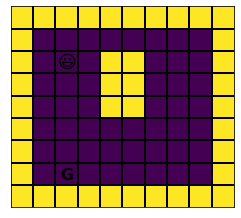

In [ ]:
environment.reset()
environment.plot_state()

Now we want to take an action using the `step` method to interact with the environment which returns a `TimeStep` 
namedtuple with fields:

```none
step_type, reward, discount, observation
``` 

We can then visualise the updated state of the grid. 

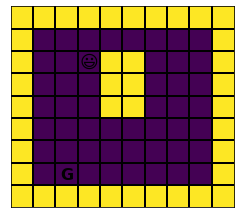

In [ ]:
timestep = environment.step(1)
environment.plot_state()

In [ ]:
#@title Helper functions for visualisation  { form-width: "30%" }

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values, epsilon=0.1):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = (1 - epsilon) * np.max(q, axis=-1) + epsilon * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
      

def smooth(x, window=10):
  return x[:window*(len(x)//window)].reshape(len(x)//window, window).mean(axis=1)
  
def plot_stats(stats, window=10):
  plt.figure(figsize=(16,4))
  plt.subplot(121)
  xline = range(0, len(stats.episode_lengths), window)
  plt.plot(xline, smooth(stats.episode_lengths, window=window))
  plt.ylabel('Episode Length')
  plt.xlabel('Episode Count')
  plt.subplot(122)
  plt.plot(xline, smooth(stats.episode_rewards, window=window))
  plt.ylabel('Episode Return')
  plt.xlabel('Episode Count')

# 2. Agent

Now that we've defined an environment, we would like to define an agent to interact with it. An agent should be able to do three things: act, according to its previous observations, observe environment timesteps (which contain observations, but also other information useful for learning, such as instantaneous rewards or discount factors). ACME direcly provide an <a href="https://github.com/deepmind/acme/blob/dbdbe5f12c740242b8504b9426e52a239dace071/acme/core.py#L34">API for agents</a>, which encapsulate this logic.

The `Actor` class has three main methods:
- `select_action` which defines the action selection process of the agent, based on the current observation.
- `observe` which takes in the current timestep, and extract the useful information (potentially placing it inside of a replay buffer).
- `update` which updates the behavior of the agent (typically by performing gradient steps on the agent parameters).

`Actor` also exposes an `observe_first` method, which specializes the `observe` method for the first observation in an episode.

Take a detailled look at the API before proceeding, we will use it to implement our DQN agent.

To facilitate training and evaluation, we directly provide a run loop, which is going to take as input an ACME `agent` and an `environment`, and is going to run the training procedure of the agent on the environment for a certain number of episodes.

We also define an evaluation loop, which also takes as input an `agent` and an `environment`, runs the agent on the environment in evaluation mode, for a certain number of episodes, and outputs corresponding frames, that can then be visualized.

In [ ]:
#@title Run loop  { form-width: "30%" }


def run_loop(environment,
             agent,
             num_episodes=None,
             num_steps=None,
             logger_time_delta=1.,
             label='training_loop',
             log_loss=False,
             ):
  """Perform the run loop.

  We are following the Acme run loop.

  Run the environment loop for `num_episodes` episodes. Each episode is itself
  a loop which interacts first with the environment to get an observation and
  then give that observation to the agent in order to retrieve an action. Upon
  termination of an episode a new episode will be started. If the number of
  episodes is not given then this will interact with the environment
  infinitely.

  Args:
    environment: dm_env used to generate trajectories.
    agent: acme.Actor for selecting actions in the run loop.
    num_steps: number of episodes to run the loop for. If `None` (default), runs
      without limit.
    num_episodes: number of episodes to run the loop for. If `None` (default),
      runs without limit.
    logger_time_delta: time interval (in seconds) between consecutive logging
      steps.
    label: optional label used at logging steps.
  """
  logger = loggers.TerminalLogger(label=label, time_delta=logger_time_delta)
  iterator = range(num_episodes) if num_episodes else itertools.count()
  all_returns = []
  
  num_total_steps = 0
  for episode in iterator:
    # Reset any counts and start the environment.
    start_time = time.time()
    episode_steps = 0
    episode_return = 0
    episode_loss = 0

    timestep = environment.reset()
    
    # Make the first observation.
    agent.observe_first(timestep)

    # Run an episode.
    while not timestep.last():
      # Generate an action from the agent's policy and step the environment.
      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)

      # Have the agent observe the timestep and let the agent update itself.
      agent.observe(action, next_timestep=timestep)
      agent.update()

      # Book-keeping.
      episode_steps += 1
      num_total_steps += 1
      episode_return += timestep.reward

      if log_loss:
        episode_loss += agent.last_loss

      if num_steps is not None and num_total_steps >= num_steps:
        break

    # Collect the results and combine with counts.
    steps_per_second = episode_steps / (time.time() - start_time)
    result = {
        'episode': episode,
        'episode_length': episode_steps,
        'episode_return': episode_return,
    }
    if log_loss:
      result['loss_avg'] = episode_loss/episode_steps

    all_returns.append(episode_return)

    # Log the given results.
    logger.write(result)
    
    if num_steps is not None and num_total_steps >= num_steps:
      break
  return all_returns

In [ ]:
#@title Evaluation loop { form-width: "30%" }

def evaluate(environment, agent, evaluation_episodes):
  frames = []

  for episode in range(evaluation_episodes):
    timestep = environment.reset()
    episode_return = 0
    steps = 0
    while not timestep.last():
      frames.append(environment.plot_state(return_rgb=True))

      action = agent.select_action(timestep.observation)
      timestep = environment.step(action)
      steps += 1
      episode_return += timestep.reward
    print(
        f'Episode {episode} ended with reward {episode_return} in {steps} steps'
    )
  return frames

def display_video(frames, filename='temp.mp4', frame_repeat=1):
  """Save and display video."""
  # Write video
  with imageio.get_writer(filename, fps=60) as video:
    for frame in frames:
      for _ in range(frame_repeat):
        video.append_data(frame)
  # Read video and display the video
  video = open(filename, 'rb').read()
  b64_video = base64.b64encode(video)
  video_tag = ('<video  width="320" height="240" controls alt="test" '
               'src="data:video/mp4;base64,{0}">').format(b64_video.decode())
  return IPython.display.HTML(video_tag)

### ***Exercise***

As a first exercise, define a random agent (i.e. an agent that outputs uniformly random actions).

In [ ]:
#@title **[Implement]** Random agent { form-width: "30%" }

class RandomAgent(acme.Actor):
  def __init__(self, environment_spec: specs.EnvironmentSpec) -> None:
    action_spec = environment_spec.actions
    assert isinstance(action_spec, dm_env.specs.DiscreteArray)
    self._num_values = self.environment_spec.action.num_values

  def select_action(self, observation: types.NestedArray) -> types.NestedArray:
    """Samples from the policy and returns an action."""
    return np.random.sample(observation)

  def observe_first(self, timestep: dm_env.TimeStep):
    """Make a first observation from the environment.
    Note that this need not be an initial state, it is merely beginning the
    recording of a trajectory.
    Args:
      timestep: first timestep.
    """
    ##### IMPLEMENT #####


  def observe(
      self,
      action: types.NestedArray,
      next_timestep: dm_env.TimeStep,
  ):
    """Make an observation of timestep data from the environment.
    Args:
      action: action taken in the environment.
      next_timestep: timestep produced by the environment given the action.
    """
    ##### IMPLEMENT #####


  def update(self, wait: bool = False):
    """Perform an update of the actor parameters from past observations.
    Args:
      wait: if True, the update will be blocking.
    """
    ##### IMPLEMENT #####


In [ ]:
#@title **[Solution]** Random agent { form-width: "30%" }

class RandomAgentSolution(acme.Actor):
  def __init__(self, environment_spec: specs.EnvironmentSpec) -> None:
    action_spec = environment_spec.actions
    assert isinstance(action_spec, dm_env.specs.DiscreteArray)
    self._num_values = action_spec.num_values

  def select_action(self, observation: types.NestedArray) -> types.NestedArray:
    """Samples from the policy and returns an action."""
    return np.random.randint(low=0, high=self._num_values)

  def observe_first(self, timestep: dm_env.TimeStep):
    """Make a first observation from the environment.
    Note that this need not be an initial state, it is merely beginning the
    recording of a trajectory.
    Args:
      timestep: first timestep.
    """
    pass

  def observe(
      self,
      action: types.NestedArray,
      next_timestep: dm_env.TimeStep,
  ):
    """Make an observation of timestep data from the environment.
    Args:
      action: action taken in the environment.
      next_timestep: timestep produced by the environment given the action.
    """
    pass

  def update(self, wait: bool = False):
    """Perform an update of the actor parameters from past observations.
    Args:
      wait: if True, the update will be blocking.
    """
    pass

Replace the `RandomAgentSolution` by your `RandomAgent` to test your implementation.

In [ ]:
run_loop(agent=RandomAgentSolution(environment_spec), environment=environment, num_episodes=3)

[0.0, -200.0, -5.0]

# 3. Introduction to JAX and Haiku

To implement our simple DQN, we will resort to neural networks as our function approximators, and we will train them, using gradient based optimizers. To make that easy, we will use <a href="https://github.com/google/jax">JAX</a>, to get access to easy gradient computations with a numpy-like flavor, and <a href="https://github.com/deepmind/dm-haiku">Haiku</a>, to easily define our neural network architectures.

## 3.1. JAX

JAX is a numerical computation library, very close to numpy for its basic use, allows one to easily execute operations on GPU, and gives access to <a href="https://github.com/google/jax#transformations">numerical function transformations</a>, that allows for gradient computations, automatic vectorization, or jitting.

JAX has a _functional_ flavor; to be able to use numerical function transformations, you will have to define _pure_ functions, i.e. mathematical functions, whose result do not depend on the context in which they are used.

For instance the following function is pure:

In [ ]:
def pure_function(x: chex.Array) -> chex.Array:
  return 3 * x + jnp.tanh(2 * x) / (x ** 2 + 1)

The following method is not pure:

In [ ]:
class Counter:
  def __init__(self) -> None:
    self._i = 0.

  def unpure_function(self, x: chex.Array) -> chex.Array:
    self._i = self._i + 1.
    return self._i * x + jnp.tanh(x)

Given a pure function, you can easily obtain the associated gradient function:

In [ ]:
grad_pure = jax.grad(pure_function)
x = 3.
print(f'Value at point x={x}, f(x)={pure_function(x)}, grad_f(x)={grad_pure(x)}')

Value at point x=3.0, f(x)=9.099998474121094, grad_f(x)=2.9400057792663574


In addition to `jax.grad`, JAX provides `jax.vmap` for automatic vectorization, `jax.jit` for jitting (to fully make use of specialized hardware) and `jax.pmap`, to automatically distribute functions accross devices.

For instance, if you want to have a batched version of matrix multiplication, you can use the usual matrix multiplication, and directly vmap it in the following way:

In [ ]:
batch_matrix_multiply = jax.vmap(lambda a, b: a @ b)
rng = jax.random.PRNGKey(0)
rng_a, rng_b = jax.random.split(rng)
a = jax.random.normal(key=rng_a, shape=(12, 5, 7))
b = jax.random.normal(key=rng_b, shape=(12, 7, 9))
print(batch_matrix_multiply(a, b).shape)

(12, 5, 9)


In this example, we have been hitting one of the differences between JAX numpy and numpy. Numpy handles random seeds _implicitly_, when you want a random
number, you get one by simply calling one of numpy's functions, and the number
will depend on numpy global seed. With JAX, random seeds are handled _explicitly_, and each function that needs to generate random numbers takes a random key as additional input. This has to do with the functional paradigm of JAX: if we were not handling the random key explicitly, each call to a random function would lead to a different result, breaking the pure function hypothesis. By passing the random key explicitly, we make sure that the same random function, called with the same random key, will produce the same result. As a side effect, this also make results produced using JAX easily reproducible, as it is easy to trace which random seeds have been used where. To
know more about how JAX handles randomness, you can read <a href="https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#rngs-and-state">this page<a>.

### ***Exercises***

As a first exercise, we are giving you the following function

In [ ]:
def func(x: chex.Array) -> chex.Array:
  return x ** 2

which simply computes the square of an array. By using simple jax transformations can you get a function that takes a batch of scalars, and outputs the value of the gradient of the squared function for each element of the batch?
As a hint: jax.grad can only take as input a function that outputs a single scalar, so calling jax.grad directly on func and applying it to a vector won't work.
Can you make it run faster?

In [ ]:
#@title **[Implement]** Batched gradients { form-width: "30%" }

batched_grad = jax.vmap(jax.grad(func))
fast_batched_grad = jax.jit(batched_grad)

In [ ]:
#@title **[Solution]** Batched gradients { form-width: "30%" }
solution_batched_grad = jax.vmap(jax.grad(func))
jitted_solution = jax.jit(solution_batched_grad)

You can test your solution by running the cell below

In [ ]:
#@title **[Test]** Batched gradients { form-width: "30%" }
key = jax.random.PRNGKey(0)
normal = jax.random.normal(key=key, shape=(3,))
if (jitted_solution(normal) == 2 * normal).all():
  print('Probably correct.')
else:
  print('Provably incorrect.')

Probably correct.


Can you do the same for a batch of batches, without flattening your input? (i.e. you have a matrix of numbers, and you want a matrix containing the gradient for each of the numbers in the matrix.)

In [ ]:
#@title **[Implement]** Matrix gradients { form-width: "30%" }
fast_matrix_grad = None

In [ ]:
#@title **[Solution]** Matrix gradients { form-width: "30%" }
jitted_solution_matrix = jax.jit(jax.vmap(jitted_solution))

In [ ]:
#@title **[Test]** Matrix gradients { form-width: "30%" }
key = jax.random.PRNGKey(0)
normal = jax.random.normal(key=key, shape=(3, 3,))
if (jitted_solution_matrix(normal) == 2 * normal).all():
  print('Probably correct.')
else:
  print('Provably incorrect.')

Probably correct.


Another very useful application of `vmap` is batched indexing. Assume you have a `[B1, B2, ..., BN]` tensor of indices `idx`, and a `[B1, B2, ..., BN, F]` tensor of features `features`, and for each element `i1, ..., iN`, you
would like to  retrieve element `features[i1, ..., iN, idx[i1, ..., iN]]` from
the feature tensor, can you do this easily using vmap? (maybe start with a fixed `N`, then generalize to all `N`'s.)

In [ ]:
#@title **[Implement]** Batched indexing { form-width: "30%" }
def batched_indexing(idxs: chex.Array, features: chex.Array) -> chex.Array:
  ##### IMPLEMENT #####
  pass

In [ ]:
#@title **[Solution]** Batched indexing { form-width: "30%" }
@jax.jit
def solution_batched_indexing(idxs: chex.Array, features: chex.Array) -> chex.Array:
  def simple_index(idx, feature):
    return feature[idx]
  batched_index = simple_index
  for _ in range(idxs.ndim):
    batched_index = jax.vmap(batched_index)
  return batched_index(idxs, features)

In [ ]:
#@title **[Test]** Batched indexing { form-width: "30%" }
inputs = jnp.array([[-0.196,  0.255,  0.573,  0.441, -0.847,  0.318,  0.646],
 [ 0.034, -0.889, -0.266, -1.561, -0.638, -0.442,  0.91 ],
 [-0.017,  0.758,  1.089,  0.299,  1.491,  0.079, -1.222],
 [ 0.952,  0.21,   1.386, -0.338,  2.952, -0.995, -0.516],
 [ 0.292, -0.143,  1.614,  1.643,  0.114,  0.254, -1.306],])
outputs = jnp.array([ 0.255, -1.561,  0.079,  1.386, -1.306])
idxs = jnp.array([1, 3, 5, 2, 6], dtype=jnp.int32)
if (solution_batched_indexing(idxs, inputs) == outputs).all():
  print('Probably correct.')
else:
  print('Provably incorrect.')

Probably correct.


## 3.2. Haiku

Haiku is to JAX what Sonnet was to TensorFlow. It allows you to simply and cleanly define (deep) neural network architectures of all kind. If you know Sonnet, or Keras, or the standard PyTorch network building facilities, you won't be too surprised by how Haiku is defining networks. 

The main difference between Haiku and those other NN libraries is the transform mechanism. As mentionned earlier, JAX works with pure function. However, the way most NN libraries build NN architectures is impure (in a functional sense): for instance, for each `torch.Module`, PyTorch defines a `forward` function, that takes the inputs of the networks, and outputs its final activations. This `forward` function is impure: it relies on the parameters of the networks, which are attributes of the encompassing object, but not given as parameters to the function each time you call it. You need to know the state of the encompassing object to get the output of the function.

On the other hand, to compute the gradient of a function, JAX requires a pure function, i.e. a function that takes both the _inputs_ of the network, as well as its _parameters_, and outputs the resulting activations. If you have such a function `f(params, inputs)`, it is straightforward to compute its gradient w.r.t. `params`, using `grad(f)(params, inputs)`. However, passing parameters around when defining network architectures would require a lot of boilerplate. To relieve the user from those considerations, Haiku allows user to define impure functions to define the architecture of the network, by only passing inputs around, then transform those impure functions into pure ones, by using `hk.transform`. Let's look at an example:



In [ ]:
def easy_linear_net(x: chex.Array) -> chex.Array:
  return hk.Linear(12)(x)

This defines a simple linear layer with 12 outputs. Similar to Keras and Sonnet, Haiku does not require you to specify the size of your input when defining linear or convolutional layers. This function is impure, as `hk.Linear` implicitly defines some parameters. Directly calling it won't work and haiku will raise an exception saying you did not transform the function first. To be able to apply the module you have created, you need first to wrap it inside a `hk.transform` in the following way:

In [ ]:
ez_linear = hk.transform(easy_linear_net)

Once transformed, `ez_linear` contains two functions, `ez_linear.init`, which takes in a random seed and an input for the network and outputs a set of parameters for your module:

In [ ]:
ez_linear_params = ez_linear.init(rng=jax.random.PRNGKey(0), x=jnp.zeros((1, 6)))
print(ez_linear_params)

FlatMapping({
  'linear': FlatMapping({
              'w': DeviceArray([[-0.394,  0.063, -0.071, -0.072, -0.28 , -0.315,  0.631,
                                 -0.383,  0.64 , -0.2  , -0.145, -0.056],
                                [-0.769,  0.334, -0.014,  0.089, -0.023, -0.268, -0.033,
                                 -0.173,  0.027, -0.155, -0.797,  0.56 ],
                                [-0.668, -0.065, -0.232,  0.636,  0.029,  0.162, -0.413,
                                  0.119, -0.419,  0.06 ,  0.012,  0.17 ],
                                [-0.232, -0.038,  0.012, -0.332, -0.355,  0.139,  0.437,
                                  0.132,  0.345, -0.052,  0.186,  0.149],
                                [ 0.813, -0.524,  0.377, -0.514, -0.294, -0.214, -0.02 ,
                                 -0.148,  0.409,  0.148, -0.059, -0.065],
                                [ 0.573, -0.063, -0.443, -0.13 , -0.7  ,  0.045, -0.265,
                                 -0.267,  0.463,  0.011,

Once you have your parameters, you can use your transformed function apply method `ez_linear.apply`, which takes in the parameters of the networks, a random seed (to cover the case of the haiku module being stochastic), and an input for the network, to get your outputs:

In [ ]:
outputs = ez_linear.apply(params=ez_linear_params, rng=jax.random.PRNGKey(0), x=jnp.ones((1, 6)))
print(outputs)

[[-0.678 -0.293 -0.37  -0.325 -1.622 -0.45   0.337 -0.721  1.465 -0.188
  -0.843  1.233]]


You can then use your apply function as you would any other pure function and compute gradients through it:

In [ ]:
def loss_fn(params: hk.Params, rng: chex.PRNGKey, inputs: chex.Array) -> chex.Array:
  return ez_linear.apply(params, rng, inputs).sum()

grad_fn = jax.grad(loss_fn)
print(grad_fn(ez_linear_params, rng, 2*jnp.ones((1, 6))))

FlatMapping({
  'linear': FlatMapping({
              'b': DeviceArray([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32),
              'w': DeviceArray([[2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
                                [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
                                [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
                                [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
                                [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.],
                                [2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.]],            dtype=float32),
            }),
})


In [ ]:
def f(x, y):
  return 2*x + 3*y

gf = jax.grad(f)
gf(2., 3.)

DeviceArray(2., dtype=float32)

### ***Exercises***

Using the linear module and the parameters defined above, fill in the following code to perform linear regression on the given dataset. You should get to a final training loss of about .94:

In [ ]:
#@title **[Implement]** Linear regression { form-width: "30%" }

inputs = jax.random.normal(key=jax.random.PRNGKey(0), shape=(128, 6))
outputs = 12 * jnp.concatenate([inputs, inputs], axis=-1) + 6 + jax.random.normal(key=jax.random.PRNGKey(0), shape=(128, 12))

rng, cur_rng = jax.random.split(jax.random.PRNGKey(0))
ez_linear_params = ez_linear.init(rng=cur_rng, x=jnp.zeros((1, 6)))

learning_rate = 1e-1
num_iterations = 500

def loss_fn(params: hk.Params, rng: chex.PRNGKey, inputs: chex.Array, targets: chex.Array) -> chex.Array:
  return ((ez_linear.apply(params, rng, inputs) - targets) ** 2.).mean()

# Implement: Define your grad function
value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))

for i in range(num_iterations):
  if i % 100 == 99:
    print(f'Loss at iteration {i}: {loss}')
  cur_rng, rng = jax.random.split(rng)
  # Implement: Call the grad function, and compute the loss function
  loss, grad = value_and_grad_fn(ez_linear_params, cur_rng, inputs, outputs)

  # This performs a gradient step. As the gradient and parameters are nested dictionaries, 
  # we have to perform the step at each of the leaf node of the nested structure.
  ez_linear_params = jax.tree_multimap(lambda p, g: p - learning_rate * g, ez_linear_params, grad)


Loss at iteration 99: 9.476552963256836
Loss at iteration 199: 1.4783633947372437
Loss at iteration 299: 0.9834994077682495
Loss at iteration 399: 0.946313738822937
Loss at iteration 499: 0.9431530237197876


In [ ]:
#@title **[Solution]** Linear regression { form-width: "30%" }
inputs = jax.random.normal(key=jax.random.PRNGKey(0), shape=(128, 6))
outputs = 12 * jnp.concatenate([inputs, inputs], axis=-1) + 6 + jax.random.normal(key=jax.random.PRNGKey(0), shape=(128, 12))

rng, cur_rng = jax.random.split(jax.random.PRNGKey(0))
ez_linear_params = ez_linear.init(rng=cur_rng, x=jnp.zeros((1, 6)))

learning_rate = 1e-1
num_iterations = 500

def loss_fn(params: hk.Params, rng: chex.PRNGKey, inputs: chex.Array, targets: chex.Array) -> chex.Array:
  preds = ez_linear.apply(params, rng, inputs)
  return jnp.mean((preds - targets) ** 2)

value_and_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
for i in range(num_iterations):
  if i % 100 == 99:
    print(f'Loss at iteration {i}: {loss}')
  cur_rng, rng = jax.random.split(rng)
  loss, grad = value_and_grad_fn(ez_linear_params, cur_rng, inputs, outputs)
  ez_linear_params = jax.tree_multimap(lambda p, g: p - learning_rate * g, ez_linear_params, grad)

Loss at iteration 99: 9.476552963256836
Loss at iteration 199: 1.4783633947372437
Loss at iteration 299: 0.9834994077682495
Loss at iteration 399: 0.946313738822937
Loss at iteration 499: 0.9431530237197876


To define our Deep-Q learning, we will put a convnet on top of our observations to approximate the Q-function. This convnet takes as input a `(9, 10, 3)` observation tensor, and should output a `(num_actions,)` tensor. Implement such a convnet. To keep things simple, we will use 2 layers of convolutions, with kernel shapes respectively 4 and 3, number of channels 32 and 64, strides 2 and 1, and VALID padding, followed by a flattening layer and 2 layers of MLP, both of size 50. We will put a relu activation between each hidden layer.

Verify that your convnet is outputting tensors of the correct shape on the dummy observations provided by the environment:

In [ ]:
#@title **[Implement]** ConvNet{ form-width: "30%" }
def network(x):
  ##### IMPLEMENT ####
  pass

net_init, net_apply = ... #### IMPLEMENT
net_output = .... ##### IMPLEMENT

if net_output.shape == (1, 4):
  print('Probably correct.')
else:
  print('Provably incorrect.')

SyntaxError: ignored

In [ ]:
#@title **[Solution]** ConvNet{ form-width: "30%" }
def network(x):
  model = hk.Sequential([
      hk.Conv2D(32, kernel_shape=[4,4], stride=[2,2], padding='VALID'),
      jax.nn.relu,
      hk.Conv2D(64, kernel_shape=[3,3], stride=[1,1], padding='VALID'),
      jax.nn.relu,
      hk.Flatten(),
      hk.nets.MLP([50, 50, environment_spec.actions.num_values])
  ])
  return model(x)



In [ ]:
#@title **[Test]** ConvNet{ form-width: "30%" }

rng = jax.random.PRNGKey(0)
net_init, net_apply = hk.without_apply_rng(hk.transform(network))
net_params = net_init(rng, timestep.observation)
net_output = net_apply(net_params, timestep.observation)

if net_output.shape == (1, 4):
  print('Probably correct.')
else:
  print('Provably incorrect.')

Probably correct.


# 4. Implementing DQN

We are now ready to get to the DQN implementation. 

In [ ]:
#@title Create the environment { form-width: "30%" }
grid = build_gridworld_task(
    task='simple', 
    observation_type=ObservationType.GRID,
    max_episode_length=200)
environment, environment_spec = setup_environment(grid)

## 4.1. ACME DQN

Before we get to a reimplementation, we are going to have a look at how the `acme.dqn` implementation does on our environment. Use the acme implementation of DQN that can be found <a href="https://github.com/deepmind/acme/blob/master/acme/agents/jax/dqn/agent.py">here</a>, and plug it inside the `run_loop` function defined earlier to train a DQN agent.

In [ ]:
#@title **[Implement]** ACME DQN { form-width: "30%" }


In [ ]:
#@title **[Solution]** ACME DQN { form-width: "30%" }
agent = dqn.DQN(
    environment_spec=environment_spec,
      network=hk.without_apply_rng(hk.transform(network)),
      batch_size=10,
      samples_per_insert=2,
      min_replay_size=10,
      epsilon=0.05,
)

In [ ]:
#@title **[Running]** ACME DQN { form-width: "30%" }
returns = run_loop(environment=environment, agent=agent, num_episodes=100, num_steps=100000, logger_time_delta=0.2 )

[Training Loop] Episode = 0 | Episode Length = 5 | Episode Return = 10.000


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


[Learner] Steps = 1
[Training Loop] Episode = 1 | Episode Length = 30 | Episode Return = -105.000
[Training Loop] Episode = 5 | Episode Length = 94 | Episode Return = -405.000
[Training Loop] Episode = 22 | Episode Length = 5 | Episode Return = 10.000
[Training Loop] Episode = 35 | Episode Length = 21 | Episode Return = 10.000
[Training Loop] Episode = 48 | Episode Length = 5 | Episode Return = 10.000
[Learner] Steps = 84
[Training Loop] Episode = 63 | Episode Length = 14 | Episode Return = -15.000
[Training Loop] Episode = 67 | Episode Length = 200 | Episode Return = -870.000
[Training Loop] Episode = 71 | Episode Length = 200 | Episode Return = -895.000
[Learner] Steps = 179
[Training Loop] Episode = 72 | Episode Length = 200 | Episode Return = -970.000
[Training Loop] Episode = 89 | Episode Length = 5 | Episode Return = 10.000


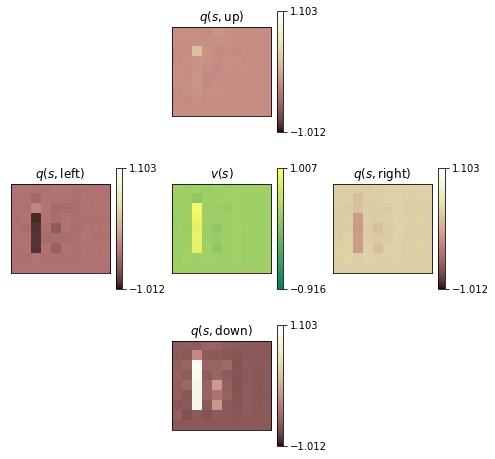

In [ ]:
# @title **[Visualising]** Learned Q values { form-width: "30%" }

# get agent parameters
params = agent._learner.get_variables([])[0]

# Evaluate the policy for every state, similar to tabular agents above.
pi = np.zeros(grid._layout_dims, dtype=np.int32)
q = np.zeros(grid._layout_dims + (4,))
for y in range(grid._layout_dims[0]):
  for x in range(grid._layout_dims[1]):
    # Hack observation to see what the Q-network would output at that point.
    environment.set_state(x, y)
    obs = environment.get_obs()
    q[y, x] = np.asarray(agent._learner._forward(params, np.expand_dims(obs, axis=0)))
    pi[y, x] = np.asarray(agent.select_action(obs))
    
plot_action_values(q)

## 4.2. Your own DQN

We will now try to implement our own version of Deep Q-learning. To do this we will first implement a `DQNLearner` class, that takes care of all the learning/updating part of DQN, then plug it inside a `DQNAgent`, that implements all the facilities to make the `DQNLearner` work properly (notably handling the replay buffer).

The DQN learner implements a loss function which is used by the learner class to compute gradients for the parameters $\theta_i$ of the Q-network $Q( \cdot; \theta_i)$:

```none
loss(params: hk.Params, target_params: hk.Params, sample: reverb.ReplaySample)
```
which, at iteration `i` computes the DQN loss $L_i$ on the parameters $\theta_i$, based on a the set of target parameters $\theta_{i-1}$ and a given batch of sampled trajectories `sample`. As described in the manuscript, the loss function is defined as:

$$L_i (\theta_i) = \mathbb{E}_{\color{red}{s},\color{blue}{a} \sim \rho(\cdot)} \left[ \left( y_i - Q(\color{red}{s},\color{blue}{a} ;\theta_i) \right)^2\right]$$

where the target $y_i$ is computed using a bootstrap value computed from Q-value network with target parameters:

$$ y_i = \mathbb{E}_{\color{red}{s'} \sim \mathcal{E}} \left[ \color{green}{r} + \gamma \max_{\color{blue}{a'} \in \color{blue}{\mathcal{A}}} Q(\color{red}{s'}, \color{blue}{a'} ; \theta^{\text{target}}_i) \; | \; \color{red}{s}, \color{blue}{a} \right] $$

The batch of data `sample` is prepackaged by the agent to match the sampling distributions $\rho$ and $\mathcal{E}$. To get the explicit data items, use the following:

```none
o_tm1, a_tm1, r_t, d_t, o_t = sample.data
```

The function is expected to return  
* `mean_loss` is the mean of the above loss over the batched data,
* (`keys`, `priorities`) will pair the `keys` corresponding to each batch item to the absolute TD-error used to compute the `mean_loss` above. The agent uses these to update priorities for samples in the replay buffer.

In [ ]:
# @title **[Implement]** DQN Learner  { form-width: "30%" }
TrainingState =  namedtuple('TrainingState', 'params, target_params, opt_state, step')
LearnerOutputs =  namedtuple('LearnerOutputs', 'keys, priorities')

class DQNLearner(acme.Learner):
  """DQN learner."""

  _state: TrainingState

  def __init__(self,
               network,
               obs_spec,
               discount,
               importance_sampling_exponent,
               target_update_period,
               data_iterator,
               optimizer,
               rng,
               replay_client,
               max_abs_reward=1.,
               huber_loss_parameter=1.,
               ):
    """Initializes the learner."""

    # ============ YOUR CODE HERE =============
    # Use provided params to initialize any jax functions used in the `step`
    # function.
    
    # Internalise agent components (replay buffer, networks, optimizer).
    self._replay_client = replay_client
    self._iterator = data_iterator

    # Since sampling is base on a priority experience replay, we need to pass
    # the absolute td-loss values to the replay client to update priorities
    # accordingly.
    def update_priorities(outputs: LearnerOutputs):
      for key, priority in zip(outputs.keys, outputs.priorities):
        self._replay_client.mutate_priorities(
            table='priority_table', 
            updates={key: priority})
        
    self._update_priorities = update_priorities

    # Internalise the hyperparameters.
    self._target_update_period = target_update_period

    # Internalise logging/counting objects.
    self._counter = counting.Counter()
    self._logger = loggers.TerminalLogger('learner', time_delta=1.)

    # Initialise parameters and optimiser state.

    # Transform network into a pure function.
    network = hk.transform(network)

    def initialization_fn(values):
      values = tree_util.tree_map(lambda x: jnp.zeros(x.shape, x.dtype), values)
      # Add batch dim.
      return tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), values)

    initial_params = network.init(next(rng), initialization_fn(obs_spec))
    initial_target_params = network.init(next(rng), initialization_fn(obs_spec))
    initial_opt_state = optimizer.init(initial_params)

    self._state = TrainingState(
        params=initial_params,
        target_params=initial_target_params,
        opt_state=initial_opt_state,
        step=0)
    
  def loss(params: hk.Params, target_params: hk.Params,
             sample: reverb.ReplaySample):
      o_tm1, a_tm1, r_t, d_t, o_t = sample.data
      keys, probs = sample.info[:2]
      
      # ============ YOUR CODE HERE =============
      # return mean_loss, (keys, priorities)

      pass
      

  def sgd_step(state, samples):
    # Compute gradients on the given loss function and update the network
    # using the optimizer provided at init time.
    grad_fn = jax.grad(loss, has_aux=True)
    gradients, (keys, priorities) = grad_fn(state.params, state.target_params,
                                            samples)
    updates, new_opt_state = optimizer.update(gradients, state.opt_state)
    new_params = optix.apply_updates(state.params, updates)

    # Update the internal state for the learner with (1) network parameters,
    # (2) parameters of the target network, (3) the state of the optimizer,
    # (4) Numbers of SGD steps performed by the agent.  
    new_state = TrainingState(
        params=new_params,
        target_params=state.target_params,
        opt_state=new_opt_state,
        step=state.step + 1)

    outputs = LearnerOutputs(keys=keys, priorities=priorities)
    return new_state, outputs

  def step(self):
    samples = next(self._iterator)
    
    # Do a batch of SGD and update self._state accordingly.
    # ============ YOUR CODE HERE =============
    
    # Update our counts and record it.
    result = self._counter.increment(steps=1)

    # Periodically update target network parameters.
    # ============ YOUR CODE HERE =============
    
    # Update priorities in replay.
    self._update_priorities(outputs)

    # Write to logs.
    self._logger.write(result)

  def get_variables(self):
    """Network variables after a number of SGD steps."""
    return self._state.params

In [ ]:
# @title **[Solution]** DQN Learner  { form-width: "30%" }

TrainingState =  namedtuple('TrainingState', 'params, target_params, opt_state, step')
LearnerOutputs =  namedtuple('LearnerOutputs', 'keys, priorities')

class DQNLearner(acme.Learner):
  """DQN learner."""

  _state: TrainingState

  def __init__(self,
               network,
               obs_spec,
               discount,
               importance_sampling_exponent,
               target_update_period,
               data_iterator,
               optimizer,
               rng,
               replay_client,
               max_abs_reward=1.,
               huber_loss_parameter=1.,
               ):
    """Initializes the learner."""

    # Transform network into a pure function.
    network = hk.without_apply_rng(hk.transform(network))

    def loss(params: hk.Params, target_params: hk.Params,
             sample: reverb.ReplaySample):
      o_tm1, a_tm1, r_t, d_t, o_t = sample.data
      keys, probs = sample.info[:2]

      # Forward pass.
      q_tm1 = network.apply(params, o_tm1)
      q_t_value = network.apply(target_params, o_t)
      q_t_selector = network.apply(params, o_t)

      # Cast and clip rewards.
      d_t = (d_t * discount).astype(jnp.float32)
      r_t = jnp.clip(r_t, -max_abs_reward, max_abs_reward).astype(jnp.float32)

      # Compute double Q-learning n-step TD-error.
      batch_error = jax.vmap(rlax.double_q_learning)
      td_error = batch_error(q_tm1, a_tm1, r_t, d_t, q_t_value, q_t_selector)
      batch_loss = rlax.huber_loss(td_error, huber_loss_parameter)

      # Importance weighting.
      importance_weights = (1. / probs).astype(jnp.float32)
      importance_weights **= importance_sampling_exponent
      importance_weights /= jnp.max(importance_weights)

      # Reweight.
      mean_loss = jnp.mean(importance_weights * batch_loss)  # []

      priorities = jnp.abs(td_error).astype(jnp.float64)

      return mean_loss, (keys, priorities)

    def sgd_step(state, samples):
      # Compute gradients on the given loss function and update the network
      # using the optimizer provided at init time.
      grad_fn = jax.grad(loss, has_aux=True)
      gradients, (keys, priorities) = grad_fn(state.params, state.target_params,
                                              samples)
      updates, new_opt_state = optimizer.update(gradients, state.opt_state)
      new_params = optax.apply_updates(state.params, updates)

      # Update the internal state for the learner with (1) network parameters,
      # (2) parameters of the target network, (3) the state of the optimizer,
      # (4) Numbers of SGD steps performed by the agent.  
      new_state = TrainingState(
          params=new_params,
          target_params=state.target_params,
          opt_state=new_opt_state,
          step=state.step + 1)

      outputs = LearnerOutputs(keys=keys, priorities=priorities)

      return new_state, outputs

    # Internalise agent components (replay buffer, networks, optimizer).
    self._replay_client = replay_client
    self._iterator = data_iterator

    # Since sampling is base on a priority experience replay, we need to pass
    # the absolute td-loss values to the replay client to update priorities
    # accordingly.
    def update_priorities(outputs: LearnerOutputs):
      for key, priority in zip(outputs.keys, outputs.priorities):
        self._replay_client.mutate_priorities(
            table='priority_table', 
            updates={key: priority})
        
    self._update_priorities = update_priorities

    # Internalise the hyperparameters.
    self._target_update_period = target_update_period

    # Internalise logging/counting objects.
    self._counter = counting.Counter()
    self._logger = loggers.TerminalLogger('learner', time_delta=1.)

    # Initialise parameters and optimiser state.
    def initialization_fn(values):
      values = tree_util.tree_map(lambda x: jnp.zeros(x.shape, x.dtype), values)
      # Add batch dim.
      return tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), values)

    initial_params = network.init(next(rng), initialization_fn(obs_spec))
    initial_target_params = network.init(next(rng), initialization_fn(obs_spec))
    initial_opt_state = optimizer.init(initial_params)

    self._state = TrainingState(
        params=initial_params,
        target_params=initial_target_params,
        opt_state=initial_opt_state,
        step=0)

    self._forward = jax.jit(network.apply)
    self._sgd_step = jax.jit(sgd_step)
    
  def step(self):
    samples = next(self._iterator)
    # Do a batch of SGD.
    self._state, outputs = self._sgd_step(self._state, samples)

    # Update our counts and record it.
    result = self._counter.increment(steps=1)

    # Periodically update target network parameters.
    if self._state.step % self._target_update_period == 0:
      self._state = self._state._replace(target_params=self._state.params)

    # Update priorities in replay.
    self._update_priorities(outputs)

    # Write to logs.
    self._logger.write(result)

  def get_variables(self):
    """Network variables after a number of SGD steps."""
    return self._state.params

In [ ]:
# @title **[Only for reference]** DQN Agent implementation { form-width: "30%" }
class DQN(acme.Actor):
  def __init__(
    self,
    environment_spec,
    network,
    batch_size=256,
    prefetch_size=4,
    target_update_period=100,
    samples_per_insert=32.0,
    min_replay_size=1000,
    max_replay_size=1000000,
    importance_sampling_exponent=0.2,
    priority_exponent=0.6,
    n_step=5,
    epsilon=0.,
    learning_rate=1e-3,
    discount=0.99,
  ):
    # Create a replay server to add data to. This is initialized as a
    # table, and a Learner (defined separately) will be in charge of updating
    # sample priorities based on the corresponding learner loss. 
    replay_table = reverb.Table(
        name='priority_table',
        sampler=reverb.selectors.Prioritized(priority_exponent),
        remover=reverb.selectors.Fifo(),
        max_size=max_replay_size,
        rate_limiter=reverb.rate_limiters.MinSize(1))
    self._server = reverb.Server([replay_table], port=None)
    address = f'localhost:{self._server.port}'

    # Use ACME reverb adder as a tool to add transition data into the replay
    # buffer defined above.
    self._adder = adders.NStepTransitionAdder(
        client=reverb.Client(address),
        n_step=n_step,
        discount=discount)

    # ACME datasets provides an interface to easily sample from a replay server.
    dataset = datasets.make_reverb_dataset(
        server_address=address,
        environment_spec=environment_spec,
        batch_size=batch_size,
        prefetch_size=prefetch_size,
        transition_adder=True)
    data_iterator = dataset.as_numpy_iterator()

    # Create a learner that updates the parameters (and initializes them).
    self._learner = DQNLearner(
        network=network,
        obs_spec=environment_spec.observations,
        rng=hk.PRNGSequence(1),
        optimizer=optax.adam(learning_rate),
        discount=discount,
        importance_sampling_exponent=importance_sampling_exponent,
        target_update_period=target_update_period,
        data_iterator=data_iterator,
        replay_client=reverb.Client(address),
    )
    
    # Create a feed forward actor that obtains its variables from the DQNLearner
    # above.
    def policy(params, key, observation):
      action_values = hk.without_apply_rng(hk.transform(network)).apply(params, observation)
      return rlax.epsilon_greedy(epsilon).sample(key, action_values)

    self._policy = policy
    self._rng = hk.PRNGSequence(1)
 
    # We'll ignore the first min_observations when determining whether to take
    # a step and we'll do so by making sure num_observations >= 0.
    self._num_observations = -max(batch_size, min_replay_size)

    observations_per_step = float(batch_size) / samples_per_insert
    if observations_per_step >= 1.0:
      self._observations_per_update = int(observations_per_step)
      self._learning_steps_per_update = 1
    else:
      self._observations_per_update = 1
      self._learning_steps_per_update = int(1.0 / observations_per_step)

  def select_action(self, observation):
    observation = tree_util.tree_map(lambda x: jnp.expand_dims(x, axis=0), 
                                     observation)
    
    key = next(self._rng)
    params = self._learner.get_variables()
    action = self._policy(params, key, observation)
    action = tree_util.tree_map(lambda x: np.array(x).squeeze(axis=0), action)
    return action 

  def observe_first(self, timestep):
    self._adder.add_first(timestep)

  def observe(self, action, next_timestep):
    self._num_observations += 1
    self._adder.add(action, next_timestep)

  def update(self):
    # Only allow updates after some minimum number of observations have been and
    # then at some period given by observations_per_update.
    if (self._num_observations >= 0 and
        self._num_observations % self._observations_per_update == 0):
      self._num_observations = 0

      # Run a number of learner steps (usually gradient steps).
      for _ in range(self._learning_steps_per_update):
        self._learner.step()

In [ ]:
# @title **[Running]** Training loop  { form-width: "30%" }

# Run a `num_episodes` training episodes.
# Rerun this cell until the agent has learned the given task.

grid = build_gridworld_task(
    task='simple', 
    observation_type=ObservationType.GRID, 
    max_episode_length=100,
)
environment, environment_spec = setup_environment(grid)

agent = DQN(
    environment_spec=environment_spec,
    network=network,
    batch_size=16,
    samples_per_insert=2,
    epsilon=0.1,
    min_replay_size=100)

returns = run_loop(environment=environment, agent=agent, num_episodes=200, 
         logger_time_delta=0.2)

[Training Loop] Episode = 0 | Episode Length = 5 | Episode Return = 10.000
[Training Loop] Episode = 2 | Episode Length = 5 | Episode Return = 10.000
[Training Loop] Episode = 4 | Episode Length = 5 | Episode Return = 10.000
[Training Loop] Episode = 6 | Episode Length = 10 | Episode Return = 5.000
[Training Loop] Episode = 8 | Episode Length = 5 | Episode Return = 10.000
[Training Loop] Episode = 9 | Episode Length = 13 | Episode Return = -20.000


/usr/local/lib/python3.7/dist-packages/jax/_src/numpy/lax_numpy.py:5256: UserWarning: Explicitly requested dtype <class 'jax._src.numpy.lax_numpy.float64'> requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


[Learner] Steps = 1
[Learner] Steps = 7
[Training Loop] Episode = 10 | Episode Length = 100 | Episode Return = -410.000
[Learner] Steps = 13
[Learner] Steps = 19
[Training Loop] Episode = 11 | Episode Length = 100 | Episode Return = -460.000
[Training Loop] Episode = 12 | Episode Length = 20 | Episode Return = -55.000
[Learner] Steps = 25
[Training Loop] Episode = 13 | Episode Length = 14 | Episode Return = -25.000
[Training Loop] Episode = 15 | Episode Length = 5 | Episode Return = 10.000
[Learner] Steps = 31
[Learner] Steps = 37
[Training Loop] Episode = 16 | Episode Length = 100 | Episode Return = -420.000
[Training Loop] Episode = 17 | Episode Length = 23 | Episode Return = -60.000
[Learner] Steps = 43
[Learner] Steps = 49
[Training Loop] Episode = 18 | Episode Length = 100 | Episode Return = -370.000
[Learner] Steps = 56
[Learner] Steps = 62
[Training Loop] Episode = 19 | Episode Length = 100 | Episode Return = -420.000
[Learner] Steps = 68
[Learner] Steps = 74
[Learner] Steps = 8